In [81]:
%matplotlib inline
# data manipulation libraries
import pandas as pd
import numpy as np
from time import time
# Graphs libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
# Libraries to study

from aif360.algorithms.preprocessing import DisparateImpactRemover, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover


# Datasets
from aif360.datasets import MEPSDataset19
# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

# ML libraries
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
# Design libraries
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")


from datetime import datetime, timedelta
import joblib
import re
import sys
sys.path.insert(0, '../')




In [2]:
dataset_orig_panel19=MEPSDataset19()

In [3]:
num_datapoints = dataset_orig_panel19.features.shape
num_datapoints

(15830, 138)

In [4]:
num_datapoints = dataset_orig_panel19.features.shape[0]
print(f"Number of datapoints in the dataset: {num_datapoints}")

Number of datapoints in the dataset: 15830


In [5]:
sens_ind = 0
sens_attr = dataset_orig_panel19.protected_attribute_names[sens_ind]
unprivileged_groups = [{sens_attr: v} for v in
                    dataset_orig_panel19.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                    dataset_orig_panel19.privileged_protected_attributes[sens_ind]]


#### Split into train and test set

In [6]:
np.random.seed(42)
data_orig_sex_train, data_orig_sex_test = dataset_orig_panel19.split([0.7], shuffle=True)
print("Perpetrator Sex :",data_orig_sex_train.features.shape)
print("Perpetrator Sex :",data_orig_sex_test.features.shape)

Perpetrator Sex : (11081, 138)
Perpetrator Sex : (4749, 138)


#### Training the model : Logistic Regression

In [7]:
rf_orig_sex = LogisticRegression().fit(data_orig_sex_train.features, 
                     data_orig_sex_train.labels.ravel(), 
                     sample_weight=data_orig_sex_train.instance_weights)

### Predict on test set

In [8]:
X_test_sex = data_orig_sex_test.features
y_test_sex = data_orig_sex_test.labels.ravel()

### METRICS

In [9]:
def get_attributes(data, selected_attr=None):
    return privileged_groups, unprivileged_groups

In [83]:
def get_model_performance(X_test, y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    return accuracy, matrix, f1, fpr, tpr, roc_auc

def plot_confusion_matrix(matrix):
    plt.figure(figsize=(8, 6))    
    sns.heatmap(matrix, annot=True, cmap='OrRd', fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve(fpr, tpr, roc_auc):
    fig = px.area(
        x=fpr, y=tpr,
        title=f'ROC curve ( Area = {roc_auc:.2f})',
        labels=dict(x='False Positive Rate', y='True Positive Rate'),
        width=600, height=600
    )
    fig.add_shape(
        type='line', line=dict(dash='dash', color='navy', width=2),
        x0=0, x1=1, y0=0, y1=1
    )
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.add_vrect(x0=0, x1=0.5, fillcolor="red", opacity=0.1, line_width=0)  
    fig.add_vrect(x0=0.5, x1=1, fillcolor="green", opacity=0.1, line_width=0) 
    fig.show()

### ACCURACY and F1 SCORE

In [84]:
def model_performance(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)
    display(Markdown('#### Accuracy of the model :'))
    print(accuracy)
    display(Markdown('#### F1 score of the model :'))
    print(f1)

model_performance(rf_orig_sex, data_orig_sex_test.features, y_test_sex)


#### Accuracy of the model :

0.866919351442409


#### F1 score of the model :

0.5182926829268293


### ROC CURVE

In [85]:
def ROC_Plot(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    loss = log_loss(y_true, probs)
    accuracy = accuracy_score(y_true, y_pred)
    accuracy1, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)
    plot_roc_curve(fpr, tpr, roc_auc)
ROC_Plot(rf_orig_sex, data_orig_sex_test.features, y_test_sex)


### CONFUSION MATRIX

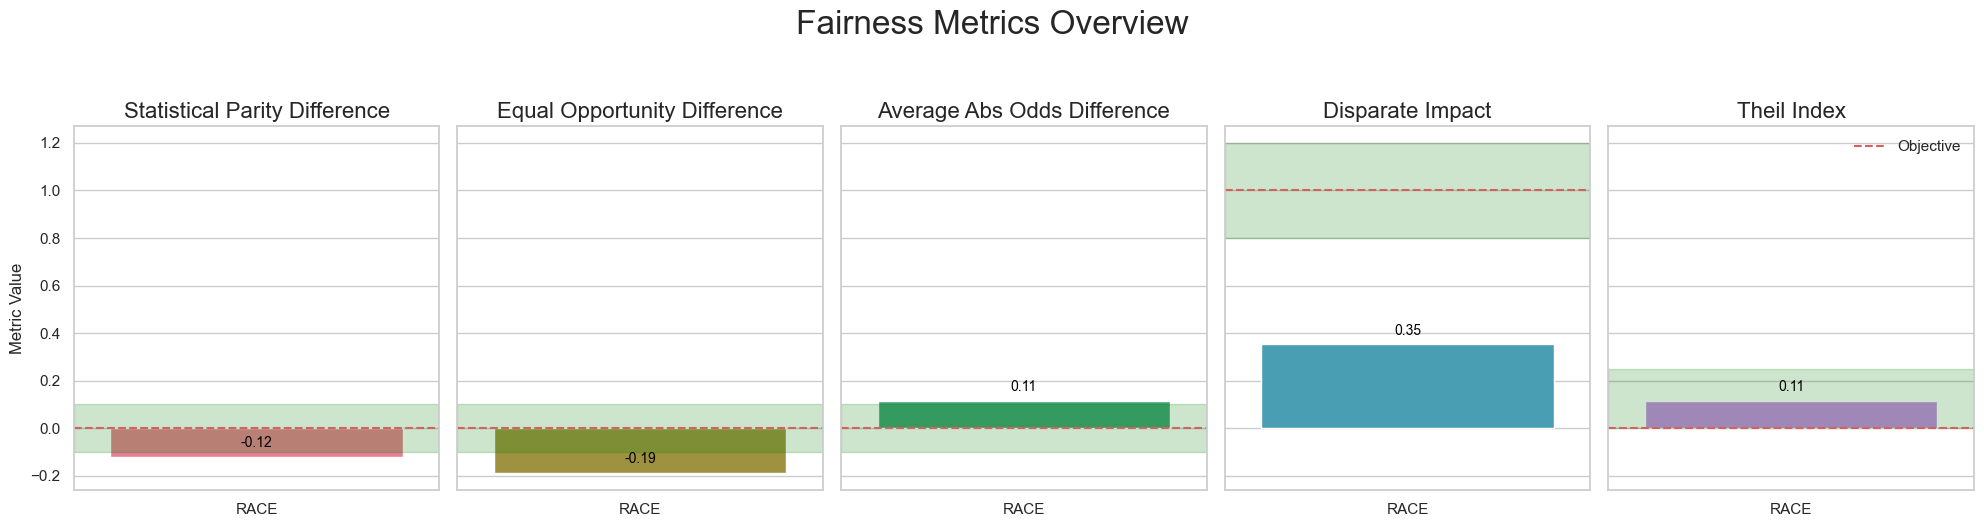

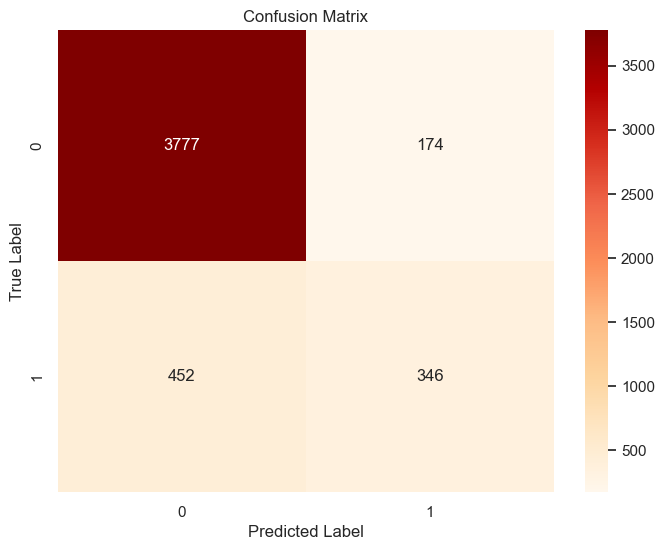

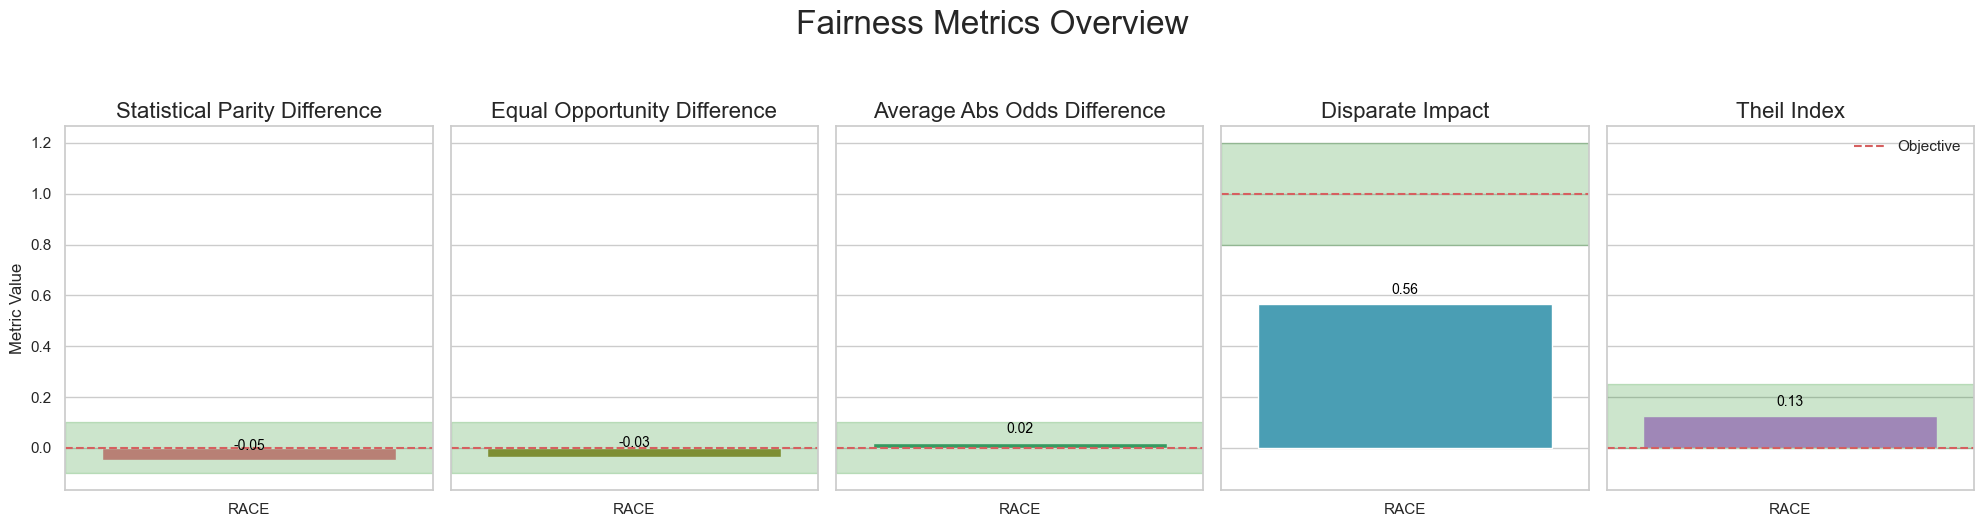

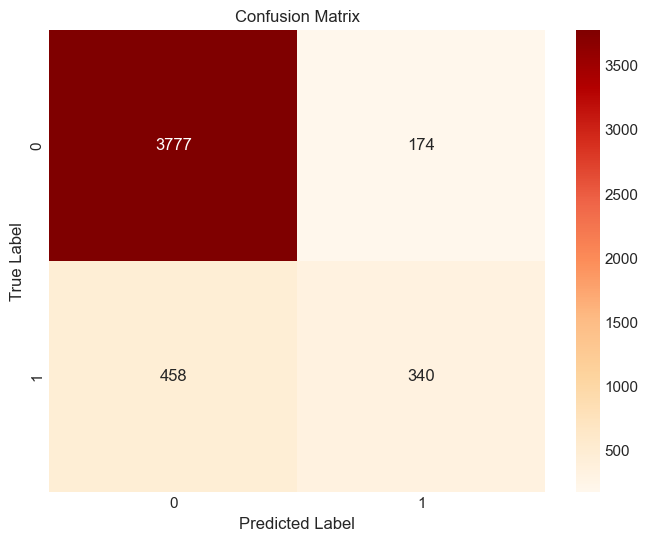

In [86]:
def Confusion_Matrix(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)
    plot_confusion_matrix(matrix)
Confusion_Matrix(rf_orig_sex, data_orig_sex_test.features, y_test_sex)

    

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, Markdown

def plot_fair_metrics(fair_metrics):
    sns.set(style="whitegrid", palette="muted")
    cols = fair_metrics.columns.values
    metrics_df = fair_metrics.iloc[1:]  # Exclude the 'objective' row for plotting
    objective_values = fair_metrics.loc['objective']
    fig, axs = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
    colors = sns.color_palette("husl", n_colors=len(cols))
    for i, col in enumerate(cols):
        bar_plot = sns.barplot(x=metrics_df.index, y=metrics_df[col], ax=axs[i], palette=[colors[i]])
        xlim = axs[i].get_xlim()
        axs[i].plot(xlim, [objective_values[col]] * 2, 'r--', label='Objective')
        axs[i].set_xlim(xlim)  # Ensure full width of the plot
        bound = [-0.1, 0.1] if i < 3 else [0.8, 1.2] if i == 3 else [0, 0.25]
        axs[i].add_patch(patches.Rectangle((xlim[0], bound[0]), xlim[1] - xlim[0], bound[1] - bound[0], color='GREEN', alpha=0.2))
        # ----- Modify here to only show the calculated value (first value of the bar)
        if len(bar_plot.patches) > 0:  # Check if there are any bars to annotate
            bar = bar_plot.patches[0]  # Get the first bar object
            height = bar.get_height()  # Get the height of the bar
            axs[i].annotate(f"{height:.2f}", (bar.get_x() + bar.get_width() / 2, height),
                             ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                             textcoords='offset points')  # Annotate the height value above the bar
        axs[i].set_title(col.replace('_', ' ').title(), fontsize=16)
        axs[i].set_xlabel('')
        axs[i].set_ylabel('Metric Value' if i == 0 else '')
    plt.suptitle('Fairness Metrics Overview', fontsize=24, y=1.05)
    plt.tight_layout()
    plt.legend()
    plt.show()

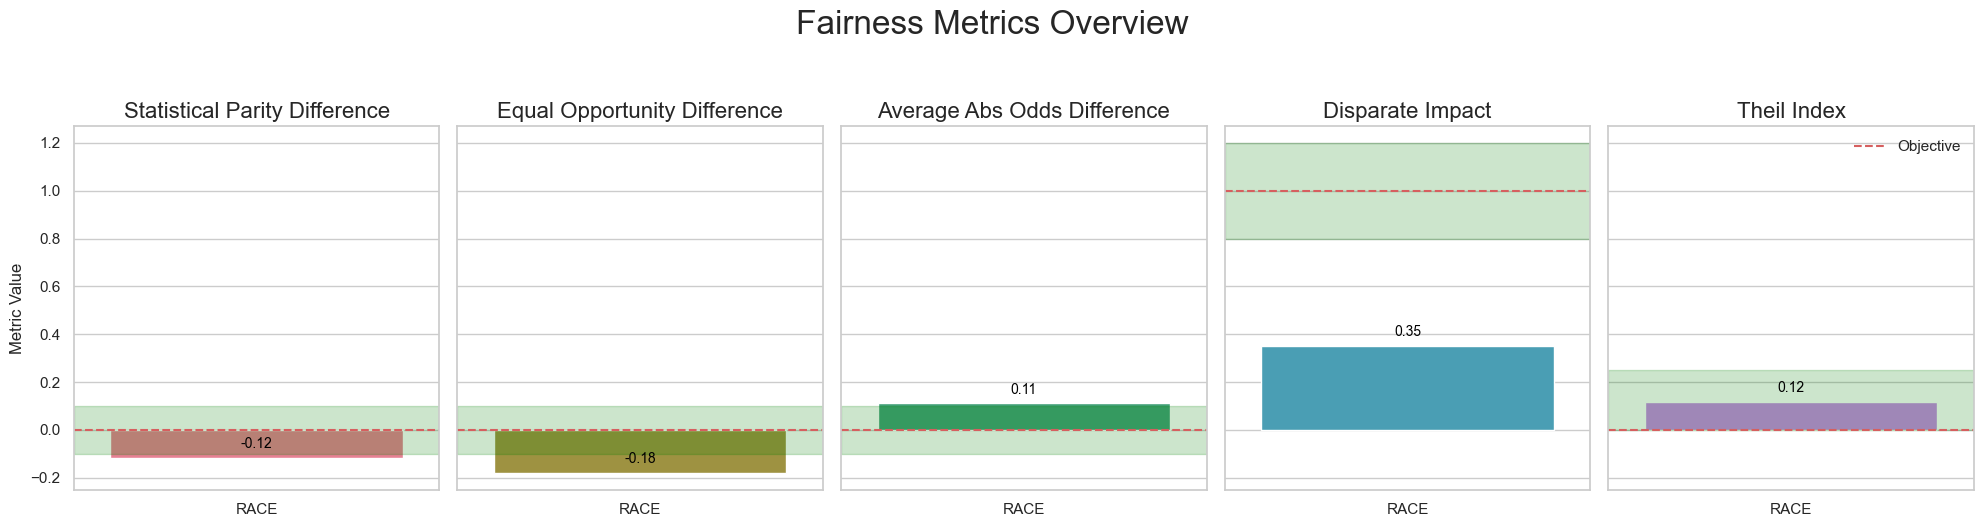

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
RACE,-0.115925,-0.181738,0.110251,0.352207,0.115688


In [88]:

def fair_metrics():
    dataset = data_orig_sex_test
    pred = rf_orig_sex.predict(dataset.features)  
    dataset_pred = dataset.copy()
    dataset_pred.labels = pred
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference', 'disparate_impact', 'theil_index']
    obj_fairness = [[0, 0, 0, 1, 0]]
    # Initialize DataFrame with objective row ---- Adjusted to initialize correctly
    fair_metrics = pd.DataFrame(data=obj_fairness, columns=cols, index=['objective'])
    rows_list = []  # Collect rows in a list for efficiency ---- Added for better performance
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups = [{attr: dataset_pred.privileged_protected_attributes[idx][0]}]
        unprivileged_groups = [{attr: dataset_pred.unprivileged_protected_attributes[idx][0]}]
        classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        # Create a dictionary for the row ---- Simplified row creation
        row_dict = {
            'statistical_parity_difference': metric_pred.mean_difference(),
            'equal_opportunity_difference': classified_metric.equal_opportunity_difference(),
            'average_abs_odds_difference': classified_metric.average_abs_odds_difference(),
            'disparate_impact': metric_pred.disparate_impact(),
            'theil_index': classified_metric.theil_index()
        }    
        rows_list.append(row_dict)  # Append dictionary to list ---- Efficient collection of rows
    # Convert list of dicts to DataFrame and concatenate with the objective row ---- Proper use of pd.concat
    if rows_list:
        new_rows_df = pd.DataFrame(rows_list, index=dataset_pred.protected_attribute_names)
        fair_metrics = pd.concat([fair_metrics, new_rows_df])
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)  # Handle infinite values
    return fair_metrics
fair = fair_metrics()
# Assuming plot_fair_metrics function exists and is correct ---- No changes made here
plot_fair_metrics(fair)
display(fair)


### DEFINING FUNCTIONS WHICH ARE USED LATER

In [89]:
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])
def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    # Using loc to add a new row to the DataFrame directly
    algo_metrics.loc[name] = [model, fair_metrics, preds, probs]
    return algo_metrics


In [90]:
data_orig_test = data_orig_sex_test
data_orig_train = data_orig_sex_train
rf = rf_orig_sex

probs = rf.predict_proba(data_orig_test.features)
preds = rf.predict(data_orig_test.features)
algo_metrics = add_to_df_algo_metrics(algo_metrics, rf, fair, preds, probs, 'Origin')

### REWEIGHING

In [91]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
t0 = time()

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
# RW.fit(data_orig_train)
data_transf_train = RW.fit_transform(data_orig_train)

# Train and save the model
rf_transf = LogisticRegression().fit(data_transf_train.features, 
                     data_transf_train.labels.ravel(), 
                     sample_weight=data_transf_train.instance_weights)

data_transf_test = RW.transform(data_orig_test)



time elapsed : 0.76s


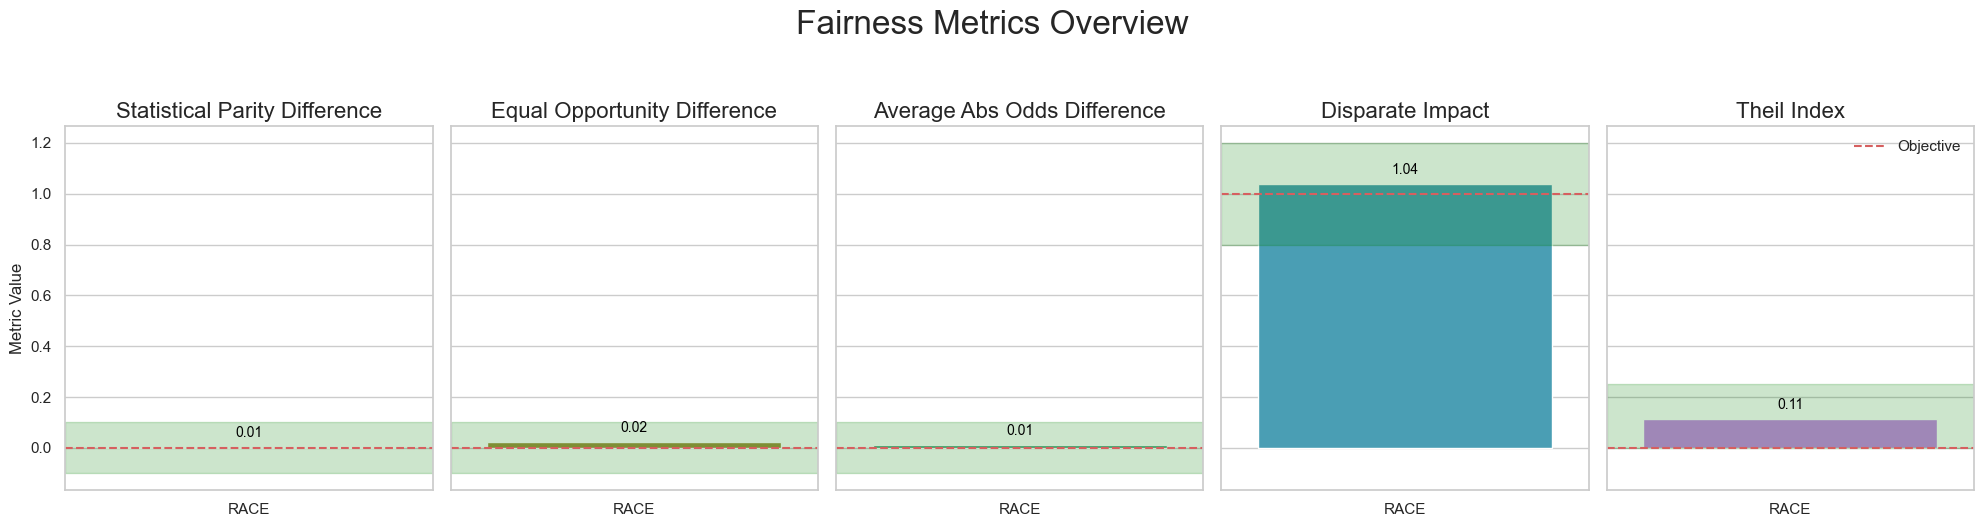

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
RACE,0.005033,0.021989,0.013078,1.039227,0.113078


In [92]:

def fair_metrics_rw():
    dataset = data_transf_test
    pred = rf_transf.predict(dataset.features)
    
    dataset_pred = dataset.copy()
    dataset_pred.labels = pred

    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference', 'disparate_impact', 'theil_index']
    obj_fairness = [[0, 0, 0, 1, 0]]

    # Initialize DataFrame with objective row ---- Adjusted to initialize correctly
    fair_metrics = pd.DataFrame(data=obj_fairness, columns=cols, index=['objective'])
    
    rows_list = []  # Collect rows in a list for efficiency ---- Added for better performance

    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups = [{attr: dataset_pred.privileged_protected_attributes[idx][0]}]
        unprivileged_groups = [{attr: dataset_pred.unprivileged_protected_attributes[idx][0]}]

        classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

        # Create a dictionary for the row ---- Simplified row creation
        row_dict = {
            'statistical_parity_difference': metric_pred.mean_difference(),
            'equal_opportunity_difference': classified_metric.equal_opportunity_difference(),
            'average_abs_odds_difference': classified_metric.average_abs_odds_difference(),
            'disparate_impact': metric_pred.disparate_impact(),
            'theil_index': classified_metric.theil_index()
        }
        
        rows_list.append(row_dict)  # Append dictionary to list ---- Efficient collection of rows

    # Convert list of dicts to DataFrame and concatenate with the objective row ---- Proper use of pd.concat
    if rows_list:
        new_rows_df = pd.DataFrame(rows_list, index=dataset_pred.protected_attribute_names)
        fair_metrics = pd.concat([fair_metrics, new_rows_df])

    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)  # Handle infinite values

    # print('fair_metrics')
    # print(fair_metrics)
    # print(type(fair_metrics))

    return fair_metrics

fair = fair_metrics_rw()




# Assuming plot_fair_metrics function exists and is correct ---- No changes made here
plot_fair_metrics(fair)
display(fair)



#### Accuracy of the model :

0.863129079806275


#### F1 score of the model :

0.5283018867924528


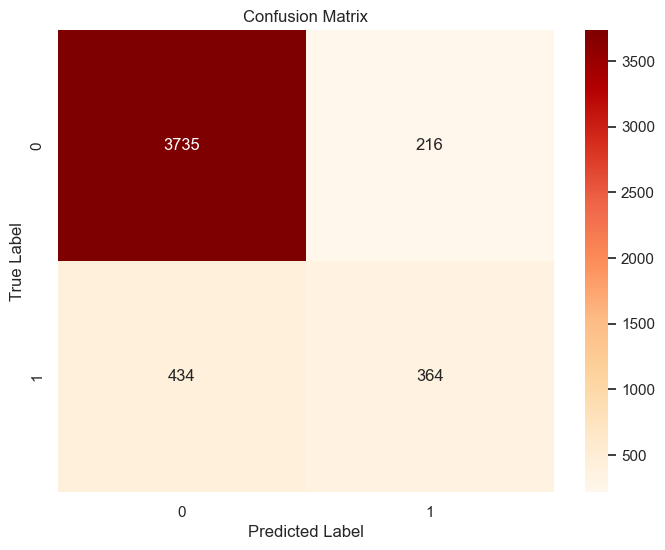

In [93]:
y_test_sex_rw = data_transf_test.labels.ravel()

model_performance(rf_transf, data_transf_test.features, y_test_sex_rw)
ROC_Plot(rf_transf, data_transf_test.features, y_test_sex_rw)
Confusion_Matrix(rf_transf, data_transf_test.features, y_test_sex)

### DISPARATE IMPACT REMOVER

In [94]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
t0 = time()

DIR = DisparateImpactRemover(repair_level=1.0)
data_transf_train = DIR.fit_transform(data_orig_train)

# Train and save the model
rf_transf_DI = LogisticRegression().fit(data_transf_train.features, 
                     data_transf_train.labels.ravel(), 
                     sample_weight=data_transf_train.instance_weights)

data_transf_test_DI = DIR.fit_transform(data_orig_test)

time elapsed : 2.23s


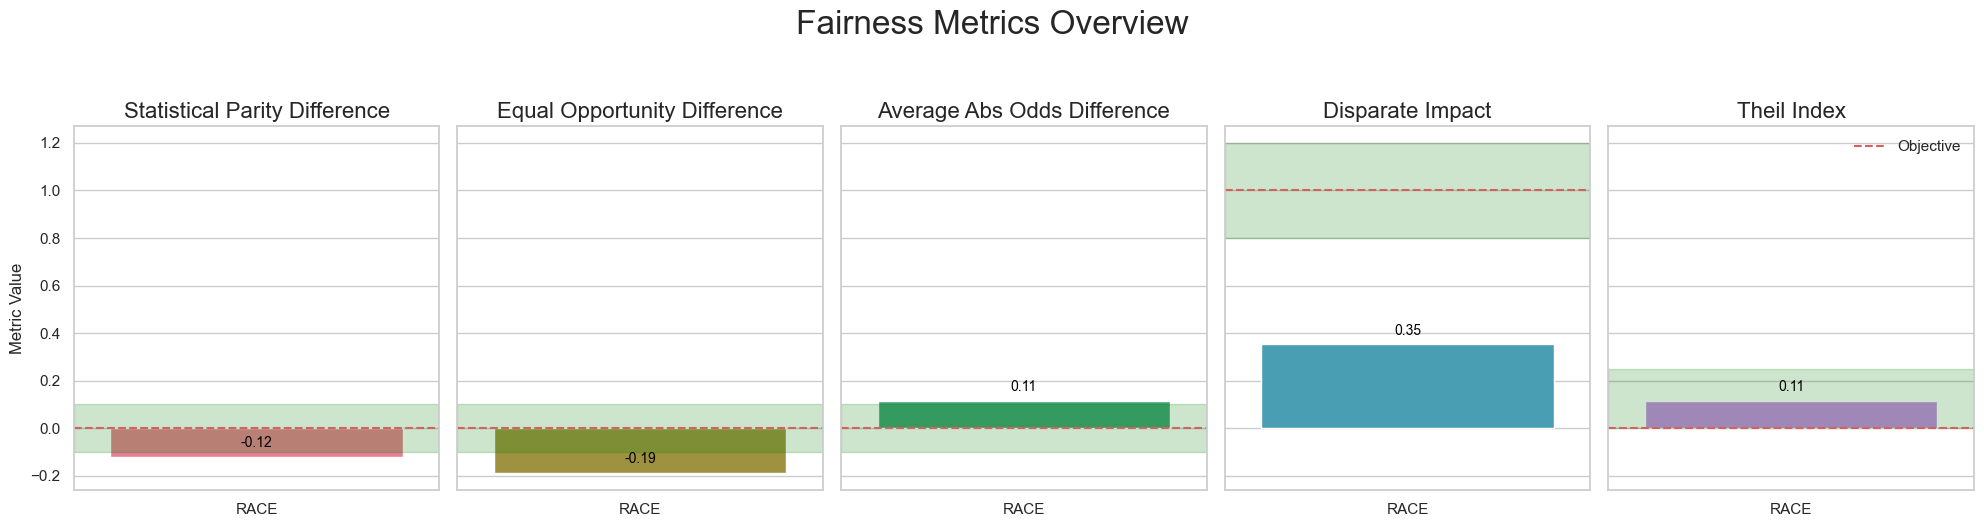

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
RACE,-0.119065,-0.189487,0.114261,0.352467,0.114273


In [95]:
def fair_metrics_DI():
    dataset = data_transf_test_DI
    pred = rf_transf_DI.predict(dataset.features)
    
    dataset_pred = dataset.copy()
    dataset_pred.labels = pred

    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference', 'disparate_impact', 'theil_index']
    obj_fairness = [[0, 0, 0, 1, 0]]

    # Initialize DataFrame with objective row ---- Adjusted to initialize correctly
    fair_metrics = pd.DataFrame(data=obj_fairness, columns=cols, index=['objective'])
    
    rows_list = []  # Collect rows in a list for efficiency ---- Added for better performance

    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups = [{attr: dataset_pred.privileged_protected_attributes[idx][0]}]
        unprivileged_groups = [{attr: dataset_pred.unprivileged_protected_attributes[idx][0]}]

        classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

        # Create a dictionary for the row ---- Simplified row creation
        row_dict = {
            'statistical_parity_difference': metric_pred.mean_difference(),
            'equal_opportunity_difference': classified_metric.equal_opportunity_difference(),
            'average_abs_odds_difference': classified_metric.average_abs_odds_difference(),
            'disparate_impact': metric_pred.disparate_impact(),
            'theil_index': classified_metric.theil_index()
        }
        
        rows_list.append(row_dict)  # Append dictionary to list ---- Efficient collection of rows

    # Convert list of dicts to DataFrame and concatenate with the objective row ---- Proper use of pd.concat
    if rows_list:
        new_rows_df = pd.DataFrame(rows_list, index=dataset_pred.protected_attribute_names)
        fair_metrics = pd.concat([fair_metrics, new_rows_df])

    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)  # Handle infinite values

    return fair_metrics

fair_DI = fair_metrics_DI()

algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf_DI, fair_DI, preds, probs, 'DISPARATE IMPACT REMOVER')
print('time elapsed : %.2fs'%(time()-t0))


# Assuming plot_fair_metrics function exists and is correct ---- No changes made here
plot_fair_metrics(fair_DI)
display(fair_DI)

#### Accuracy of the model :

0.8681827753211202


#### F1 score of the model :

0.5250379362670713


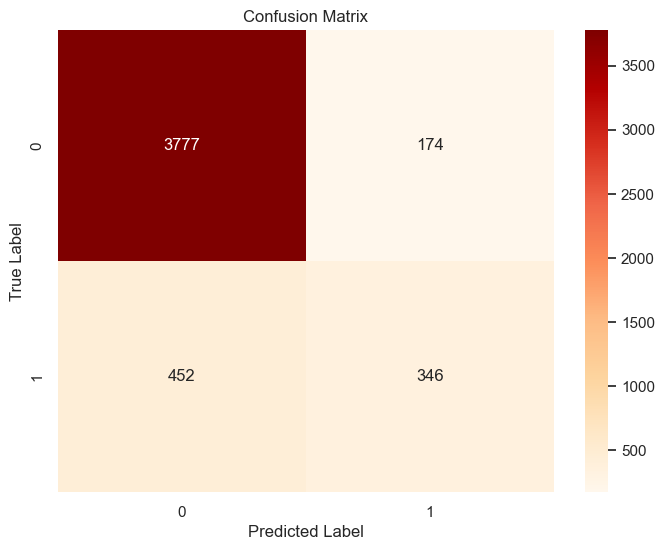

In [96]:
y_test_sex_DI = data_transf_test_DI.labels.ravel()

model_performance(rf_transf_DI, data_transf_test_DI.features, y_test_sex_DI)
ROC_Plot(rf_transf_DI, data_transf_test_DI.features, y_test_sex_DI)
Confusion_Matrix(rf_transf_DI, data_transf_test_DI.features, y_test_sex_DI)

### ADVERSARIAL DEBIASING

In [24]:
data_orig_test.features

array([[46.  ,  1.  , 54.39, ...,  1.  ,  0.  ,  0.  ],
       [31.  ,  1.  , 56.15, ...,  1.  ,  0.  ,  0.  ],
       [59.  ,  1.  , 54.8 , ...,  1.  ,  0.  ,  0.  ],
       ...,
       [53.  ,  1.  , 31.76, ...,  0.  ,  1.  ,  0.  ],
       [33.  ,  0.  , 57.76, ...,  1.  ,  0.  ,  0.  ],
       [21.  ,  0.  , 41.44, ...,  1.  ,  0.  ,  0.  ]])

In [25]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['RACE'])
t0 = time()
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Now you can use Session as you did in TensorFlow 1.x
sess2 = tf.Session()

debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          num_epochs=10,
                          debias=True,
                          sess=sess2)

debiased_model.fit(data_orig_train)



Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2024-05-04 21:07:17.221926: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 1.608079; batch adversarial loss: 0.854341
epoch 1; iter: 0; batch classifier loss: 0.603297; batch adversarial loss: 0.701015
epoch 2; iter: 0; batch classifier loss: 0.441963; batch adversarial loss: 0.690415
epoch 3; iter: 0; batch classifier loss: 0.279543; batch adversarial loss: 0.662025
epoch 4; iter: 0; batch classifier loss: 0.343660; batch adversarial loss: 0.679853
epoch 5; iter: 0; batch classifier loss: 0.305189; batch adversarial loss: 0.665114
epoch 6; iter: 0; batch classifier loss: 0.396766; batch adversarial loss: 0.659516
epoch 7; iter: 0; batch classifier loss: 0.272041; batch adversarial loss: 0.669291
epoch 8; iter: 0; batch classifier loss: 0.359243; batch adversarial loss: 0.658095
epoch 9; iter: 0; batch classifier loss: 0.288321; batch adversarial loss: 0.644946


In [26]:

def fair_metrics_AD():
    dataset = data_orig_test
    pred = debiased_model.predict(data_orig_test).labels 
    
    dataset_pred = dataset.copy()
    dataset_pred.labels = pred

    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference', 'disparate_impact', 'theil_index']
    obj_fairness = [[0, 0, 0, 1, 0]]

    # Initialize DataFrame with objective row ---- Adjusted to initialize correctly
    fair_metrics = pd.DataFrame(data=obj_fairness, columns=cols, index=['objective'])
    
    rows_list = []  # Collect rows in a list for efficiency ---- Added for better performance

    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups = [{attr: dataset_pred.privileged_protected_attributes[idx][0]}]
        unprivileged_groups = [{attr: dataset_pred.unprivileged_protected_attributes[idx][0]}]

        classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

        # Create a dictionary for the row ---- Simplified row creation
        row_dict = {
            'statistical_parity_difference': metric_pred.mean_difference(),
            'equal_opportunity_difference': classified_metric.equal_opportunity_difference(),
            'average_abs_odds_difference': classified_metric.average_abs_odds_difference(),
            'disparate_impact': metric_pred.disparate_impact(),
            'theil_index': classified_metric.theil_index()
        }
        
        rows_list.append(row_dict)  # Append dictionary to list ---- Efficient collection of rows

    # Convert list of dicts to DataFrame and concatenate with the objective row ---- Proper use of pd.concat
    if rows_list:
        new_rows_df = pd.DataFrame(rows_list, index=dataset_pred.protected_attribute_names)
        fair_metrics = pd.concat([fair_metrics, new_rows_df])

    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)  # Handle infinite values
    return fair_metrics,pred

fair,pred = fair_metrics_AD()



data_pred = debiased_model.predict(data_orig_test)
algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'AdvDebiasing')
print('time elapsed : %.2fs'%(time()-t0))

# Assuming plot_fair_metrics function exists and is correct ---- No changes made here
plot_fair_metrics(fair)
display(fair)



time elapsed : 10.46s


,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
RACE,-0.049186,-0.034582,0.017979,0.564731,0.126952


### Done Debugging :D

In [ ]:
def Confusion_Matrix_ad(model, X_test, y_true):
    y_pred = model.predict(data_orig_test).labels.flatten()
    # print(y_pred)
    pos_probs = model.predict(X_test).scores
    negative_class_probs = 1 - pos_probs

# Combine to form the new array with both classes
    probs = np.hstack((negative_class_probs, pos_probs))
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)
    plot_confusion_matrix(matrix)

    

In [ ]:
def ROC_Plot_ad(model, X_test, y_true):
    y_pred = model.predict(data_orig_test).labels.flatten()
    # print(y_pred)
    pos_probs = model.predict(X_test).scores
    negative_class_probs = 1 - pos_probs

# Combine to form the new array with both classes
    probs = np.hstack((negative_class_probs, pos_probs))
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)
    plot_roc_curve(fpr, tpr, roc_auc)

In [ ]:
y_test_sex_ad = data_orig_test.labels.ravel()

# model_performance(debiased_model, data_orig_train.features, y_test_sex_rw)
ROC_Plot_ad(debiased_model, data_orig_test, y_test_sex_ad)
# Confusion_Matrix(debiased_model, data_orig_train.features, y_test_sex)
Confusion_Matrix_ad(debiased_model, data_orig_test, y_test_sex_ad)



### PREJUDICE REMOVER

In [ ]:
t0 = time()
debiased_model_PR = PrejudiceRemover(sensitive_attr="RACE", eta = 25.0)
debiased_model_PR.fit(data_orig_train)


In [ ]:

def fair_metrics_PR():
    dataset = data_orig_train
    pred = debiased_model_PR.predict(data_orig_train).labels 
    
    dataset_pred = dataset.copy()
    dataset_pred.labels = pred

    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference', 'disparate_impact', 'theil_index']
    obj_fairness = [[0, 0, 0, 1, 0]]

    # Initialize DataFrame with objective row ---- Adjusted to initialize correctly
    fair_metrics = pd.DataFrame(data=obj_fairness, columns=cols, index=['objective'])
    
    rows_list = []  # Collect rows in a list for efficiency ---- Added for better performance

    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups = [{attr: dataset_pred.privileged_protected_attributes[idx][0]}]
        unprivileged_groups = [{attr: dataset_pred.unprivileged_protected_attributes[idx][0]}]

        classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

        # Create a dictionary for the row ---- Simplified row creation
        row_dict = {
            'statistical_parity_difference': metric_pred.mean_difference(),
            'equal_opportunity_difference': classified_metric.equal_opportunity_difference(),
            'average_abs_odds_difference': classified_metric.average_abs_odds_difference(),
            'disparate_impact': metric_pred.disparate_impact(),
            'theil_index': classified_metric.theil_index()
        }
        
        rows_list.append(row_dict)  # Append dictionary to list ---- Efficient collection of rows

    # Convert list of dicts to DataFrame and concatenate with the objective row ---- Proper use of pd.concat
    if rows_list:
        new_rows_df = pd.DataFrame(rows_list, index=dataset_pred.protected_attribute_names)
        fair_metrics = pd.concat([fair_metrics, new_rows_df])

    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)  # Handle infinite values

    print('fair_metrics')
    print(fair_metrics)
    print(type(fair_metrics))

    return fair_metrics

fair = fair_metrics_PR()



data_pred = debiased_model_PR.predict(data_orig_test)
algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model_PR, fair, data_pred.labels, data_pred.scores, 'Prejudice Remover')
print('time elapsed : %.2fs'%(time()-t0))


# Assuming plot_fair_metrics function exists and is correct ---- No changes made here
plot_fair_metrics(fair)
display(fair)



### Done Debugging

In [ ]:
def Confusion_Matrix_pr(model, X_test, y_true):
    y_pred = model.predict(data_orig_test).labels.flatten()
    print(y_pred)
    pos_probs = model.predict(X_test).scores
    negative_class_probs = 1 - pos_probs
# Combine to form the new array with both classes
    probs = np.hstack((negative_class_probs, pos_probs))
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)
    plot_confusion_matrix(matrix)

    

In [ ]:
def ROC_Plot_pr(model, X_test, y_true):
    y_pred = model.predict(data_orig_test).labels.flatten()
    print(y_pred)
    pos_probs = model.predict(X_test).scores
    negative_class_probs = 1 - pos_probs
# Combine to form the new array with both classes
    probs = np.hstack((negative_class_probs, pos_probs))
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)
    plot_roc_curve(fpr, tpr, roc_auc)

In [ ]:

y_test_sex_pr = data_orig_test.labels.ravel()
# model_performance(debiased_model_PR, data_orig_train.features, y_test_sex_rw)
ROC_Plot_pr(debiased_model_PR, data_orig_test, y_test_sex_pr)
Confusion_Matrix_pr(debiased_model_PR, data_orig_test, y_test_sex_pr)

### LOSS FUNCTION WITH DISCRIMINATION

In [ ]:
dataset_orig_panel19_train = MEPSDataset19()

sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]
unprivileged_groups = [{sens_attr: v} for v in
                    dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                    dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Prepare data
X = dataset_orig_panel19_train.features
y = dataset_orig_panel19_train.labels.ravel()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = X_train
X_test_scaled = X_test

# Train logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Predict probabilities on the same scaled training data
train_probabilities = model.predict_proba(X_train_scaled)[:, 1]

# Calculation of discrimination index without modifying dataset structure
sens_attr_index = dataset_orig_panel19_train.feature_names.index('RACE')



# Define unprivileged and privileged values
unprivileged_val = 0.0
privileged_val = 1.0



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Removed sigmoid to get raw logits
        return x.squeeze()

# Custom loss function that considers discrimination
def discrimination_loss(output, target, sensitive_features, lambda_val=100, k=2):
    criterion = nn.BCEWithLogitsLoss()
    standard_loss = criterion(output, target)

    mask_unpriv = (sensitive_features == 0)
    mask_priv = (sensitive_features == 1)
    prob_unpriv = torch.sigmoid(output[mask_unpriv]).mean()
    prob_priv = torch.sigmoid(output[mask_priv]).mean()
    discrimination = lambda_val * (prob_priv - prob_unpriv) ** k
    loss_val = (1 + discrimination) * standard_loss

    return loss_val, discrimination.item()

def calculate_accuracy(predictions, targets):
    predicted_classes = (predictions.sigmoid() >= 0.5).float()
    return (predicted_classes == targets).float().mean()

def predict(model, input_tensor):
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = (output.sigmoid() >= 0.5).int()
        return predicted_class.item()

def predict_proba(model, input_tensor):
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        predicted_prob = output.sigmoid()
        return (1 - predicted_prob).item(), predicted_prob.item()

# Data preparation
data = torch.tensor(X_train_scaled).float()
targets = torch.tensor(y_train).float().unsqueeze(1)
sensitive_features = torch.tensor((data[:, 1].numpy() > 0.5).astype(float)).float()
features = torch.cat((data[:, :1], data[:, 2:]), dim=1)

test_data = torch.tensor(X_test_scaled).float()
test_targets = torch.tensor(y_test).float().unsqueeze(1)
test_sensitive_features = torch.tensor((test_data[:, 1].numpy() > 0.5).astype(float)).float()
test_features = torch.cat((test_data[:, :1], test_data[:, 2:]), dim=1)

model = BinaryClassifier(features.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.01)
final_epoch_predictions=None
final_epoch_probabilities=None
# Training and testing loop
final_epoch=100
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(features)
    loss, discrimination = discrimination_loss(outputs, targets.squeeze(), sensitive_features)
    train_accuracy = calculate_accuracy(outputs, targets.squeeze())
    loss.backward()
    optimizer.step()

    # Model evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_features)
        test_loss, test_discrimination = discrimination_loss(test_outputs, test_targets.squeeze(), test_sensitive_features)
        test_accuracy = calculate_accuracy(test_outputs, test_targets.squeeze())
        if epoch == final_epoch - 1:
            final_epoch_predictions=(test_outputs.sigmoid() >= 0.5).int()
            prob_positive = test_outputs.sigmoid()
            prob_negative = 1 - prob_positive

            # Stack the probabilities to create a 2D tensor with both class probabilities
            final_epoch_probabilities = torch.stack((prob_negative, prob_positive), dim=1)


    print(f'Epoch {epoch+1}, Train Loss: {loss.item()}, Train Acc: {train_accuracy.item()*100:.2f}%, Train Discrimination: {discrimination}, '
          f'Test Loss: {test_loss.item()}, Test Acc: {test_accuracy.item()*100:.2f}%, Test Discrimination: {test_discrimination}')
    model.train()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, Markdown

def plot_fair_metrics(fair_metrics):
    sns.set(style="whitegrid", palette="muted")
    
    cols = fair_metrics.columns.values
    metrics_df = fair_metrics.iloc[1:]  # Exclude the 'objective' row for plotting
    objective_values = fair_metrics.loc['objective']

    fig, axs = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
    colors = sns.color_palette("husl", n_colors=len(cols))

    for i, col in enumerate(cols):
        bar_plot = sns.barplot(x=metrics_df.index, y=metrics_df[col], ax=axs[i], palette=[colors[i]])

        xlim = axs[i].get_xlim()
        axs[i].plot(xlim, [objective_values[col]] * 2, 'r--', label='Objective')
        axs[i].set_xlim(xlim)  # Ensure full width of the plot

        bound = [-0.1, 0.1] if i < 3 else [0.8, 1.2] if i == 3 else [0, 0.25]
        axs[i].add_patch(patches.Rectangle((xlim[0], bound[0]), xlim[1] - xlim[0], bound[1] - bound[0], color='GREEN', alpha=0.2))

        # ----- Modify here to only show the calculated value (first value of the bar)
        if len(bar_plot.patches) > 0:  # Check if there are any bars to annotate
            bar = bar_plot.patches[0]  # Get the first bar object
            height = bar.get_height()  # Get the height of the bar
            axs[i].annotate(f"{height:.2f}", (bar.get_x() + bar.get_width() / 2, height),
                             ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                             textcoords='offset points')  # Annotate the height value above the bar

        axs[i].set_title(col.replace('_', ' ').title(), fontsize=16)
        axs[i].set_xlabel('')
        axs[i].set_ylabel('Metric Value' if i == 0 else '')

    plt.suptitle('Fairness Metrics Overview', fontsize=24, y=1.05)
    plt.tight_layout()
    plt.legend()

    plt.show()


In [ ]:
# dataset_orig_panel19=MEPSDataset19()
data_orig_sex_train, data_orig_sex_test = dataset_orig_panel19.split([0.7], shuffle=True)

def fair_metrics():
    dataset=data_orig_sex_test
    pred=final_epoch_predictions.numpy()
    pred_proba=final_epoch_probabilities.numpy()
    dataset_pred = data_orig_sex_test
    dataset_pred.labels = pred

    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference', 'disparate_impact', 'theil_index']
    obj_fairness = [[0, 0, 0, 1, 0]]

    # Initialize DataFrame with objective row ---- Adjusted to initialize correctly
    fair_metrics = pd.DataFrame(data=obj_fairness, columns=cols, index=['objective'])
    
    rows_list = []  # Collect rows in a list for efficiency ---- Added for better performance

    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups = [{attr: dataset_pred.privileged_protected_attributes[idx][0]}]
        unprivileged_groups = [{attr: dataset_pred.unprivileged_protected_attributes[idx][0]}]

        classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

        # Create a dictionary for the row ---- Simplified row creation
        row_dict = {
            'statistical_parity_difference': metric_pred.mean_difference(),
            'equal_opportunity_difference': classified_metric.equal_opportunity_difference(),
            'average_abs_odds_difference': classified_metric.average_abs_odds_difference(),
            'disparate_impact': metric_pred.disparate_impact(),
            'theil_index': classified_metric.theil_index()
        }
        
        rows_list.append(row_dict)  # Append dictionary to list ---- Efficient collection of rows

    # Convert list of dicts to DataFrame and concatenate with the objective row ---- Proper use of pd.concat
    if rows_list:
        new_rows_df = pd.DataFrame(rows_list, index=dataset_pred.protected_attribute_names)
        fair_metrics = pd.concat([fair_metrics, new_rows_df])

    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)  # Handle infinite values

    # print('fair_metrics')
    # print(fair_metrics)
    # print(type(fair_metrics))

    return fair_metrics

fair = fair_metrics()

# Assuming plot_fair_metrics function exists and is correct ---- No changes made here
plot_fair_metrics(fair)
display(fair)


In [ ]:
# dataset=data_orig_sex_test
# pred=final_epoch_predictions.numpy()
# pred_proba=final_epoch_probabilities.numpy()
# dataset_pred = data_orig_sex_test
# dataset_pred.labels = pred

In [ ]:

# def ROC_Plot_disc(X_test, y_true,y_pred,pred_proba):
#     #y_pred = model.predict(X_test)
#     #probs = model.predict_proba(X_test)
#     accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

#     plot_roc_curve(fpr, tpr, roc_auc)
    
# ROC_Plot_disc(data_orig_sex_test.features, data_orig_sex_test.labels,pred,predict_proba)
-0.123118		0.		0.104548

In [66]:
# # lambda = 100, k =2


# Model = ['BASE MODEL', 'REWEIGHING','DISPARATE IMPACT REMOVER','ADVERSARIAL DEBIASING', 'PREJUDICE REMOVER','MODEL WITH DISC IN LOSS FUNCTION']
# stat = ['-0.11843','0.001649','-0.121844','-0.053664','-0.024841','0.000414']
# eq_op = ['-0.197133','0.010389','-0.207568','-0.043402','0.009017','0.00000']
# abs_odds = ['0.116694','0.006653','0.123159','0.02403','0.006213','0.00000']
# disp_imp = ['0.353492','1.012789','0.33208','0.547452','0.59515','1.005809']
# theil = ['0.114186','0.113549','0.115176','0.126379','0.152623','0.00000']

# FinalMetrics_df = pd.DataFrame({
#     'MODEL NAME': Model,
#     'STATISTICAL_PARITY_DIFFERENCE': stat,
#     'EQUAL_OPPORTUNITY_DIFFERENCE': eq_op,
#     'AVERAGE_ABS_ODDS_DIFFERENCE': abs_odds,
#     'DISPARATE_IMPACT': disp_imp,
#     'THEIL_INDEX' : theil,
# })

# FinalMetrics_df

,MODEL NAME,STATISTICAL_PARITY_DIFFERENCE,EQUAL_OPPORTUNITY_DIFFERENCE,AVERAGE_ABS_ODDS_DIFFERENCE,DISPARATE_IMPACT,THEIL_INDEX
0,BASE MODEL,-0.11843,-0.197133,0.116694,0.353492,0.114186
1,REWEIGHING,0.001649,0.010389,0.006653,1.012789,0.113549
2,DISPARATE IMPACT REMOVER,-0.121844,-0.207568,0.123159,0.33208,0.115176
3,ADVERSARIAL DEBIASING,-0.053664,-0.043402,0.02403,0.547452,0.126379
4,PREJUDICE REMOVER,-0.024841,0.009017,0.006213,0.59515,0.152623
5,MODEL WITH DISC IN LOSS FUNCTION,0.000414,0.00000,0.00000,1.005809,0.00000


In [70]:
import pandas as pd

# Defining the models and their metrics
Model = ['BASE MODEL', 'REWEIGHING', 'DISPARATE IMPACT REMOVER', 'ADVERSARIAL DEBIASING', 'PREJUDICE REMOVER', 'MODEL WITH DISC IN LOSS FUNCTION']
stat = [-0.11843, 0.001649, -0.121844, -0.053664, -0.024841, 0.000414]
eq_op = [-0.197133, 0.010389, -0.207568, -0.043402, 0.009017, 0.00000]
abs_odds = [0.116694, 0.006653, 0.123159, 0.02403, 0.006213, 0.00000]
disp_imp = [0.353492, 1.012789, 0.33208, 0.547452, 0.59515, 1.005809]
theil = [0.114186, 0.113549, 0.115176, 0.126379, 0.152623, 0.00000]

# Creating DataFrame with the model names as the index
FinalMetrics_df = pd.DataFrame({
    'STATISTICAL_PARITY_DIFFERENCE': stat,
    'EQUAL_OPPORTUNITY_DIFFERENCE': eq_op,
    'AVERAGE_ABS_ODDS_DIFFERENCE': abs_odds,
    'DISPARATE_IMPACT': disp_imp,
    'THEIL_INDEX': theil
}, index=Model)

FinalMetrics_df


,STATISTICAL_PARITY_DIFFERENCE,EQUAL_OPPORTUNITY_DIFFERENCE,AVERAGE_ABS_ODDS_DIFFERENCE,DISPARATE_IMPACT,THEIL_INDEX
BASE MODEL,-0.118430,-0.197133,0.116694,0.353492,0.114186
REWEIGHING,0.001649,0.010389,0.006653,1.012789,0.113549
DISPARATE IMPACT REMOVER,-0.121844,-0.207568,0.123159,0.332080,0.115176
ADVERSARIAL DEBIASING,-0.053664,-0.043402,0.024030,0.547452,0.126379
PREJUDICE REMOVER,-0.024841,0.009017,0.006213,0.595150,0.152623
MODEL WITH DISC IN LOSS FUNCTION,0.000414,0.000000,0.000000,1.005809,0.000000


In [79]:
import plotly.graph_objs as go

def plot_fair_metrics_plotly2(fair_metrics):
    # Prepare data
    data = fair_metrics.values.T  # Transpose to get metrics as columns
    cols = fair_metrics.columns
    index = fair_metrics.index

    # Create heatmap
    fig = go.Figure(data=go.Heatmap(
        z=data,
        x=index,  # Models on the x-axis
        y=cols,  # Metrics on the y-axis
        colorscale='RdBu',  # Red to blue color scale, good for centered data
        zmid=0  # Center the color scale at zero
    ))

    # Update layout
    fig.update_layout(
        title='Fairness Metrics Across Models',
        xaxis_nticks=36,
        yaxis=dict(title='Metric', autorange='reversed'),  # Reverse to show the top as the start
        xaxis=dict(title='Models'),
        plot_bgcolor='white'
    )
    fig.show()

def plot_fair_metrics_plotly(fair_metrics):
    bottom = [-1, -1, -1, 0, 0]
    max_valid = [0.1, 0.1, 0.1, 1.2, 0.25]
    min_valid = [-0.1, -0.1, -0.1, 0.8, 0]
    cols = fair_metrics.columns.values

    for i in range(0, 5):
        col = cols[i]

        x, y = (fair_metrics[col].values, fair_metrics.index)
        colors = []
        for v in x:
            color = '#e74c3c' if v < min_valid[i] or v > max_valid[i] else '#2ecc71'
            colors.append(color)

        trace = go.Bar(x=x, y=y, marker=dict(color=colors)
                       , opacity=0.9, orientation='h')

        layout = go.Layout(barmode='group',
                           title=col,
                           xaxis=dict(range=[bottom[i], bottom[i] + 2]),
                           yaxis=go.layout.YAxis(automargin=True),
                           shapes=[
                               {
                                   'type': 'line',
                                   'x0': min_valid[i],
                                   'y0': -1,
                                   'x1': min_valid[i],
                                   'y1': len(y),
                                   'line': {
                                       'color': 'rgb(0, 0, 0)',
                                       'width': 2,
                                   },
                               }, {
                                   'type': 'line',
                                   'x0': max_valid[i],
                                   'y0': -1,
                                   'x1': max_valid[i],
                                   'y1': len(y),
                                   'line': {
                                       'color': 'rgb(0, 0, 0)',
                                       'width': 2,
                                   },
                               }])
        fig = go.Figure([trace], layout=layout)
        py.iplot(fig)


def plot_score_fair_metrics(score):
    display(score.sort_values(['nb_valid', 'score'], ascending=[0, 1]))
    score.sort_values(['nb_valid', 'score'], ascending=[1, 0], inplace=True)

    gold, silver, bronze, other = ('#FFA400', '#bdc3c7', '#cd7f32', '#3498db')
    colors = [gold if i == 0 else silver if i == 1 else bronze if i == 2 else other for i in range(0, len(score))]
    colors = [c for c in reversed(colors)]

    x, y = (score['score'].values, score.index)

    trace = go.Bar(x=x, y=y, marker=dict(color=colors)
                   , opacity=0.9, orientation='h')
    layout = go.Layout(barmode='group',
                       title='Fairest algorithm',
                       yaxis=go.layout.YAxis(automargin=True))
    fig = go.Figure([trace], layout=layout)
    py.iplot(fig)
    

def score_fair_metrics(fair):
    objective = [0, 0, 0, 1, 0]
    max_valid = [0.1, 0.1, 0.1, 1.2, 0.25]
    min_valid = [-0.1, -0.1, -0.1, 0.8, 0]

    nb_valid = np.sum(((fair.values > min_valid) * (fair.values < max_valid)), axis=1)
    score = np.sum(np.abs(fair.values - objective), axis=1)
    score = np.array([score, nb_valid])

    score = pd.DataFrame(data=score.transpose(), columns=['score', 'nb_valid'], index=fair.index)
    return score


def score_all_attr(algo_metrics):
    attributes = algo_metrics.loc['Origin', 'fair_metrics'].index.values[1:]

    all_scores = np.zeros((len(algo_metrics), 2))
    for attr in attributes:
        df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin', 'fair_metrics'].columns.values)
        for fair in algo_metrics.loc[:, 'fair_metrics']:
            df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)
        all_scores = all_scores + score_fair_metrics(df_metrics).values

    final = pd.DataFrame(data=all_scores, columns=['score', 'nb_valid'], index=algo_metrics.index)
    return final


In [80]:
display(FinalMetrics_df)
plot_fair_metrics_plotly(FinalMetrics_df)
plot_fair_metrics_plotly2(FinalMetrics_df)
score = score_fair_metrics(FinalMetrics_df)
plot_score_fair_metrics(score.dropna())

,STATISTICAL_PARITY_DIFFERENCE,EQUAL_OPPORTUNITY_DIFFERENCE,AVERAGE_ABS_ODDS_DIFFERENCE,DISPARATE_IMPACT,THEIL_INDEX
BASE MODEL,-0.118430,-0.197133,0.116694,0.353492,0.114186
REWEIGHING,0.001649,0.010389,0.006653,1.012789,0.113549
DISPARATE IMPACT REMOVER,-0.121844,-0.207568,0.123159,0.332080,0.115176
ADVERSARIAL DEBIASING,-0.053664,-0.043402,0.024030,0.547452,0.126379
PREJUDICE REMOVER,-0.024841,0.009017,0.006213,0.595150,0.152623
MODEL WITH DISC IN LOSS FUNCTION,0.000414,0.000000,0.000000,1.005809,0.000000


,score,nb_valid
REWEIGHING,0.145029,5.0
MODEL WITH DISC IN LOSS FUNCTION,0.006223,4.0
PREJUDICE REMOVER,0.597544,4.0
ADVERSARIAL DEBIASING,0.700023,4.0
BASE MODEL,1.192951,1.0
DISPARATE IMPACT REMOVER,1.235667,1.0
